In [ ]:
pip install bertopic

  Using cached bertopic-0.16.4-py3-none-any.whl.metadata (23 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manyl

Install libraries

In [ ]:
import pandas as pd
import io
from google.colab import files
from bertopic import BERTopic

Load data

In [ ]:
#load data
uploaded = files.upload()
uploaded_1 = files.upload()



Saving kc_osm_dbscan_tag.csv to kc_osm_dbscan_tag.csv


Saving new_kc_osm.csv to new_kc_osm.csv


In [ ]:
#load osm data for kc
kc_osm_dbscan_tag= pd.read_csv(io.BytesIO(uploaded['kc_osm_dbscan_tag.csv']))
osm_kc = kc_osm_dbscan_tag['value'].tolist()


In [ ]:
#load osm data for KC
kc_osm_data= pd.read_csv(io.BytesIO(uploaded_1['new_kc_osm.csv']))
#Melt the dataframe
value_vars = ['properties.amenity', 'properties.healthcare', 'properties.office', 'properties.historic', 'properties.natural',
              'properties.shop', 'properties.tourism', 'properties.leisure', 'properties.sport', 'properties.aeroway', 'properties.man_made',
              'properties.waterway']
id_vars = [x for x in kc_osm_data.columns if x not in value_vars]
kc_osm_data2 = pd.melt(kc_osm_data,
                       id_vars=id_vars,
                       value_vars=value_vars,
                       var_name= 'key',
                       value_name= 'value')
#remove none values from tags
kc_osm_data2 = kc_osm_data2.dropna(subset=['value'])
#select certain columns
kc_osm_data2 = kc_osm_data2[["geometry.coordinates", "properties.@osmId", "key", "value"]]
#convert to geopandas dataframe
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame
kc_osm_data2['geometry.coordinates'] = kc_osm_data2['geometry.coordinates'].apply(lambda x: Point(eval(x)))
#plot the data
kc_osm_data2 = gpd.GeoDataFrame(kc_osm_data2, geometry = 'geometry.coordinates', crs="EPSG:4326").to_crs('epsg:27700')

<ipython-input-9-3f0118710a59>:2: DtypeWarning: Columns (8,11,24,31,44,57,62,64,77,79,81,82,83,84,85,86,87,89,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,122,123,124,125,126,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,144,145,146,148,149,150,151,152,153,154,155,156,157,158,159,160,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,259,260,261,262,263,265,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,293,294,295,296,297,298,299,300,301,303,304,305,307,309,310,311,312,314,316,317,318,319,320,321,322,323,325,326,327,328,329,330,331,332,3

In [ ]:
#remove unnecessary values
kc_osm_data2 = kc_osm_data2[~(kc_osm_data2.value.isin(["yes"]))]
kc_osm_data2['easting'] = kc_osm_data2['geometry.coordinates'].x
kc_osm_data2['northing'] = kc_osm_data2['geometry.coordinates'].y
kc_coords = kc_osm_data2[['easting', 'northing']].to_numpy()

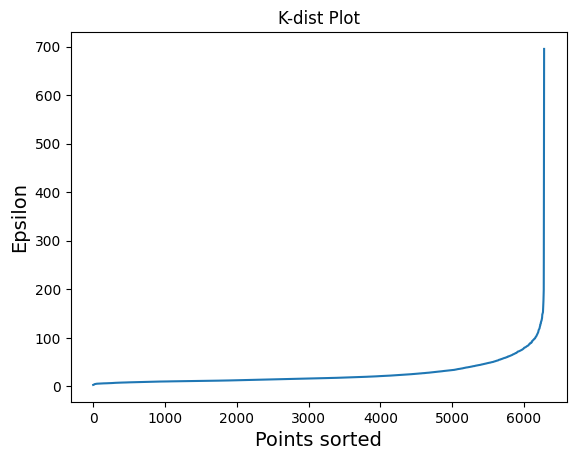

In [ ]:
#finding the optimum epsilon
#Codes adopted from https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(kc_coords)
#distance between each point and its k nearest neighbour
distances, indices = neighbors_fit.kneighbors(kc_coords)
#sort distances in ascending order
distances = np.sort(distances, axis=0)
distances = distances[:,3]
#plot distances
plt.title('K-dist Plot')
plt.xlabel('Points sorted', fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.plot(distances)

In [ ]:
#run dbscan
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=60, min_samples=4, metric='euclidean')
db = dbscan.fit(kc_coords)
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
num_noise = list(cluster_labels).count(-1)
print(num_clusters)
print(num_noise)

100
367


In [ ]:
#add cluster labels to dataset
kc_osm_data2['cluster'] = cluster_labels
#remove noise
remove = kc_osm_data2[kc_osm_data2['cluster'] == -1].index
kc_osm_data3 = kc_osm_data2.drop(remove)
#get tag list for each dbscan cluster as a list
osm_kc_dbscan = kc_osm_data3.groupby('cluster')['value'].apply(list)
data_dbscan = pd.DataFrame(osm_kc_dbscan)
tag_list_dbscan = data_dbscan.value.values.tolist()
data_dbscan

,value
cluster,
0,"[post_box, parking_entrance, dentist, dentist,..."
1,"[restaurant, cafe, memorial, hairdresser]"
2,"[post_box, pharmacy, post_box, bicycle_parking..."
3,"[restaurant, telephone, telephone, telephone, ..."
4,"[bicycle_rental, post_box, telephone, bicycle_..."
...,...
94,"[post_box, tree, tree, tree, tree, tree, tree,..."
95,"[charity, charity, memorial, tree, tree]"
96,"[tree, tree, tree, tree, tree, tree]"


[<POLYGON ((524555.666 178976.909, 524513.29 179049.878, 524655.843 179628.99...>, <POLYGON ((525310.882 179168.768, 525323.229 179193.919, 525371.014 179213.5...>, <POLYGON ((525475.752 179045.95, 525478.455 179049.844, 525499.303 179077.52...>, <POLYGON ((525528.057 178052.749, 525470.266 178090.814, 525376.058 178754.2...>, <POLYGON ((525178.734 178644.206, 525119.373 178705.224, 525162.49 178734.69...>, <POLYGON ((524923.62 178770.947, 524923.274 178809.672, 525012.803 178834.60...>, <POLYGON ((525230.576 178953.193, 525230.5 179070.527, 525261.143 179071.37,...>, <POLYGON ((526168.199 177094.487, 525933.828 177386.523, 525966.503 177447.7...>, <POLYGON ((526442.15 178512.366, 526439.48 178514.125, 526435.448 178518.442...>, <POLYGON ((526612.479 178462.157, 526610.523 178512.304, 526637.129 178470.0...>, <POLYGON ((527619.589 179336.913, 527584.876 179408.893, 527631.757 179517.3...>, <POLYGON ((527970.456 179324.289, 527941.538 179331.116, 527963.252 179376.7...>, <POLYGON ((5270

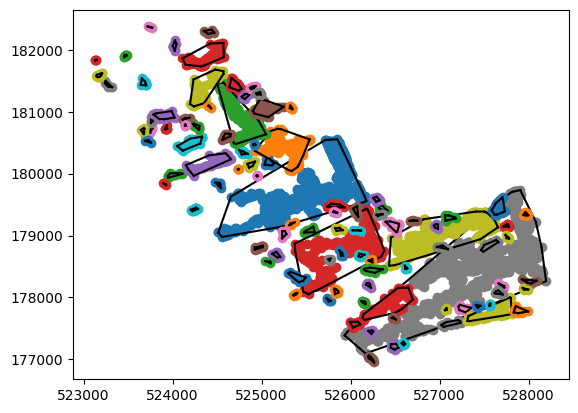

In [ ]:
#Regionalise
#create convex hull
#Reference https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.ConvexHull.html
import scipy
import numpy
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import matplotlib.pyplot as plt

#select only necessary column
db_cl = kc_osm_data3[["easting",
                   "northing",
                   "cluster"]]

#run convexhull for each clusters seperately
#create a list of convex hull
h = [] #for list of polygon coordinates from chull
for i in range(0,99):
    cluster_i = db_cl.loc[db_cl['cluster']==i]
    db_cl_i = cluster_i[["easting", "northing"]].to_numpy()
    ch_i = ConvexHull(db_cl_i)
    h.append(db_cl_i[ch_i.vertices,:].tolist())
    plt.plot(db_cl_i[:, 0],db_cl_i[:, 1],  'o')
    for simplex in ch_i.simplices:
        ploted=plt.plot(db_cl_i[simplex, 0], db_cl_i[simplex, 1],'k-')
#for generating polygon from ordered manner
#Ref: https://stackoverflow.com/questions/61740032/how-to-convert-convex-hull-vertices-into-a-geopandas-polygon
from shapely.geometry import MultiPoint
c_h = []
for hull in h:
    c_h.append(MultiPoint(hull).convex_hull)

print(c_h)

In [ ]:
#run model
#extract embeddings
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
#reduce dimension
from umap import UMAP
umap_model = UMAP(n_neighbors=5,
                  min_dist=0.0,
                  metric='cosine')
#clustering
from hdbscan import HDBSCAN
hdbscan_model = HDBSCAN(min_cluster_size = 4,
                        min_samples = 3,
                        gen_min_span_tree = True,
                        prediction_data = True)

#Tokenize topics
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

# Create topic representation
from bertopic.vectorizers import ClassTfidfTransformer
ctfidf_model = ClassTfidfTransformer()

#run model
topic_model = BERTopic( embedding_model=embedding_model,
                        umap_model=umap_model,
                        hdbscan_model=hdbscan_model,
                        vectorizer_model=cv,
                        ctfidf_model=ctfidf_model,
                        language="english",
                        calculate_probabilities=True,
                        verbose=True)

topics, probs = topic_model.fit_transform(osm_kc)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2025-03-11 16:35:36,725 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

2025-03-11 16:35:42,094 - BERTopic - Embedding - Completed ✓
2025-03-11 16:35:42,095 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-11 16:35:48,586 - BERTopic - Dimensionality - Completed ✓
2025-03-11 16:35:48,587 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-11 16:35:48,600 - BERTopic - Cluster - Completed ✓
2025-03-11 16:35:48,606 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-11 16:35:48,630 - BERTopic - Representation - Completed ✓


In [ ]:
topic_model.visualize_barchart(title = 'Topic word scores for OSM POI tags', top_n_topics =12 )

In [ ]:
bertopic_df = pd.DataFrame(topic_model.get_document_info(osm_kc))
bertopic_df

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,"['post_box', 'parking_entrance', 'dentist', 'd...",1,1_tree_restaurant_bench_clothes,"[tree, restaurant, bench, clothes, bicycle_par...","[['post_box', 'parking_entrance', 'dentist', '...",tree - restaurant - bench - clothes - bicycle_...,0.455827,True
1,"['restaurant', 'cafe', 'memorial', 'hairdresser']",8,8_beauty_gallery_memorial_jewelry,"[beauty, gallery, memorial, jewelry, equestria...","[['pharmacy', 'parking', 'cafe', 'pharmacy', '...",beauty - gallery - memorial - jewelry - equest...,1.000000,False
2,"['post_box', 'pharmacy', 'post_box', 'bicycle_...",6,6_convenience_fast_food_bookmaker_pharmacy,"[convenience, fast_food, bookmaker, pharmacy, ...","[['post_box', 'pharmacy', 'post_box', 'bicycle...",convenience - fast_food - bookmaker - pharmacy...,1.000000,True
3,"['restaurant', 'telephone', 'telephone', 'tele...",1,1_tree_restaurant_bench_clothes,"[tree, restaurant, bench, clothes, bicycle_par...","[['post_box', 'parking_entrance', 'dentist', '...",tree - restaurant - bench - clothes - bicycle_...,0.468754,False
4,"['bicycle_rental', 'post_box', 'telephone', 'b...",0,0_bicycle_parking_clinic_motorcycle_parking_re...,"[bicycle_parking, clinic, motorcycle_parking, ...","[['recycling', 'bicycle_parking', 'telephone',...",bicycle_parking - clinic - motorcycle_parking ...,0.342275,False
...,...,...,...,...,...,...,...,...
94,"['post_box', 'tree', 'tree', 'tree', 'tree', '...",3,3_tree_music_venue_car_wash_hostel,"[tree, music_venue, car_wash, hostel, playgrou...","[['post_box', 'tree', 'tree', 'tree', 'tree', ...",tree - music_venue - car_wash - hostel - playg...,1.000000,True
95,"['charity', 'charity', 'memorial', 'tree', 'tr...",2,2_memorial_post_box_charging_station_bicycle_p...,"[memorial, post_box, charging_station, bicycle...","[['parking', 'diplomatic', 'memorial', 'memori...",memorial - post_box - charging_station - bicyc...,0.261877,False
96,"['tree', 'tree', 'tree', 'tree', 'tree', 'tree']",3,3_tree_music_venue_car_wash_hostel,"[tree, music_venue, car_wash, hostel, playgrou...","[['post_box', 'tree', 'tree', 'tree', 'tree', ...",tree - music_venue - car_wash - hostel - playg...,1.000000,True
97,"['tree', 'tree', 'tree', 'tree', 'hostel']",3,3_tree_music_venue_car_wash_hostel,"[tree, music_venue, car_wash, hostel, playgrou...","[['post_box', 'tree', 'tree', 'tree', 'tree', ...",tree - music_venue - car_wash - hostel - playg...,0.221060,False


In [ ]:
topic_model.get_topic_freq()

,Topic,Count
3,0,14
0,1,11
6,2,11
5,-1,10
8,3,9
7,4,8
4,5,7
2,6,6
12,7,6
1,8,5


In [ ]:
topic_model.generate_topic_labels()

['-1_clothes_dentist_tree',
 '0_bicycle_parking_clinic_motorcycle_parking',
 '1_tree_restaurant_bench',
 '2_memorial_post_box_charging_station',
 '3_tree_music_venue_car_wash',
 '4_bench_artwork_motorcycle_parking',
 '5_estate_agent_interior_design_motorcycle_parking',
 '6_convenience_fast_food_bookmaker',
 '7_gallery_company_post_box',
 '8_beauty_gallery_memorial',
 '9_tower_rugs_dance',
 '10_carpet_interior_decoration_fountain',
 '11_bench_post_box_charity']

In [ ]:
#Name the bertopic topics
def get_osm_bertopic_name(Topic):
    if Topic == 0:
        return 'Vehicle Parking Zone'
    elif Topic == 6:
        return 'Local shopping street '
    elif Topic == 7:
        return 'Gallery & Studio'
    elif Topic == 8:
        return 'High Street Shopping'
    elif Topic == 11:
        return 'Urban Park & Green Space'
    else:
        return 'Others'
bertopic_df['BERTopic_OSM'] = bertopic_df['Topic'].apply(get_osm_bertopic_name)


Evaluate Topics

In [ ]:
#code adopted from https://github.com/MaartenGr/BERTopic/issues/90
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
import numpy as np
documents = pd.DataFrame({"Document": osm_kc,
                          "ID": range(len(osm_kc)),
                          "Topic": topics})
documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

# Extract vectorizer and analyzer from BERTopic
vectorizer = topic_model.vectorizer_model
analyzer = vectorizer.build_analyzer()

# Extract features for Topic Coherence evaluation
#words = vectorizer.get_feature_names()
tokens = [analyzer(doc) for doc in cleaned_docs]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words = [[words for words, _ in topic_model.get_topic(topic)]
               for topic in range(len(set(topics))-1)]

# Evaluate
coherence_model = CoherenceModel(topics=topic_words,
                                 texts=tokens,
                                 corpus=corpus,
                                 dictionary=dictionary,
                                 coherence='u_mass')
coherence = coherence_model.get_coherence()
coherence

-0.5181559914520636

In [ ]:
##add c_h polygon coordinates
bertopic_df['geometry'] = c_h
#set index as column
bertopic_df['cluster'] = bertopic_df.index

In [ ]:
bertopic_df

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document,BERTopic_OSM,geometry,cluster
0,"['post_box', 'parking_entrance', 'dentist', 'd...",1,1_tree_restaurant_bench_clothes,"[tree, restaurant, bench, clothes, bicycle_par...","[['post_box', 'parking_entrance', 'dentist', '...",tree - restaurant - bench - clothes - bicycle_...,0.455827,True,Others,"POLYGON ((524555.6658644185 178976.909243548, ...",0
1,"['restaurant', 'cafe', 'memorial', 'hairdresser']",8,8_beauty_gallery_memorial_jewelry,"[beauty, gallery, memorial, jewelry, equestria...","[['pharmacy', 'parking', 'cafe', 'pharmacy', '...",beauty - gallery - memorial - jewelry - equest...,1.000000,False,High Street Shopping,"POLYGON ((525310.8820236693 179168.7678943912,...",1
2,"['post_box', 'pharmacy', 'post_box', 'bicycle_...",6,6_convenience_fast_food_bookmaker_pharmacy,"[convenience, fast_food, bookmaker, pharmacy, ...","[['post_box', 'pharmacy', 'post_box', 'bicycle...",convenience - fast_food - bookmaker - pharmacy...,1.000000,True,Local shopping street,"POLYGON ((525475.751724326 179045.95000695804,...",2
3,"['restaurant', 'telephone', 'telephone', 'tele...",1,1_tree_restaurant_bench_clothes,"[tree, restaurant, bench, clothes, bicycle_par...","[['post_box', 'parking_entrance', 'dentist', '...",tree - restaurant - bench - clothes - bicycle_...,0.468754,False,Others,POLYGON ((525528.0572911138 178052.74908822373...,3
4,"['bicycle_rental', 'post_box', 'telephone', 'b...",0,0_bicycle_parking_clinic_motorcycle_parking_re...,"[bicycle_parking, clinic, motorcycle_parking, ...","[['recycling', 'bicycle_parking', 'telephone',...",bicycle_parking - clinic - motorcycle_parking ...,0.342275,False,Vehicle Parking Zone,POLYGON ((525178.7337754932 178644.20590446383...,4
...,...,...,...,...,...,...,...,...,...,...,...
94,"['post_box', 'tree', 'tree', 'tree', 'tree', '...",3,3_tree_music_venue_car_wash_hostel,"[tree, music_venue, car_wash, hostel, playgrou...","[['post_box', 'tree', 'tree', 'tree', 'tree', ...",tree - music_venue - car_wash - hostel - playg...,1.000000,True,Others,POLYGON ((526233.2124297569 177412.40132826456...,94
95,"['charity', 'charity', 'memorial', 'tree', 'tr...",2,2_memorial_post_box_charging_station_bicycle_p...,"[memorial, post_box, charging_station, bicycle...","[['parking', 'diplomatic', 'memorial', 'memori...",memorial - post_box - charging_station - bicyc...,0.261877,False,Others,"POLYGON ((526508.4509707259 177644.5084731992,...",95
96,"['tree', 'tree', 'tree', 'tree', 'tree', 'tree']",3,3_tree_music_venue_car_wash_hostel,"[tree, music_venue, car_wash, hostel, playgrou...","[['post_box', 'tree', 'tree', 'tree', 'tree', ...",tree - music_venue - car_wash - hostel - playg...,1.000000,True,Others,"POLYGON ((524948.4482268306 179957.8665645516,...",96
97,"['tree', 'tree', 'tree', 'tree', 'hostel']",3,3_tree_music_venue_car_wash_hostel,"[tree, music_venue, car_wash, hostel, playgrou...","[['post_box', 'tree', 'tree', 'tree', 'tree', ...",tree - music_venue - car_wash - hostel - playg...,0.221060,False,Others,"POLYGON ((525764.2425398994 178593.3223985823,...",97


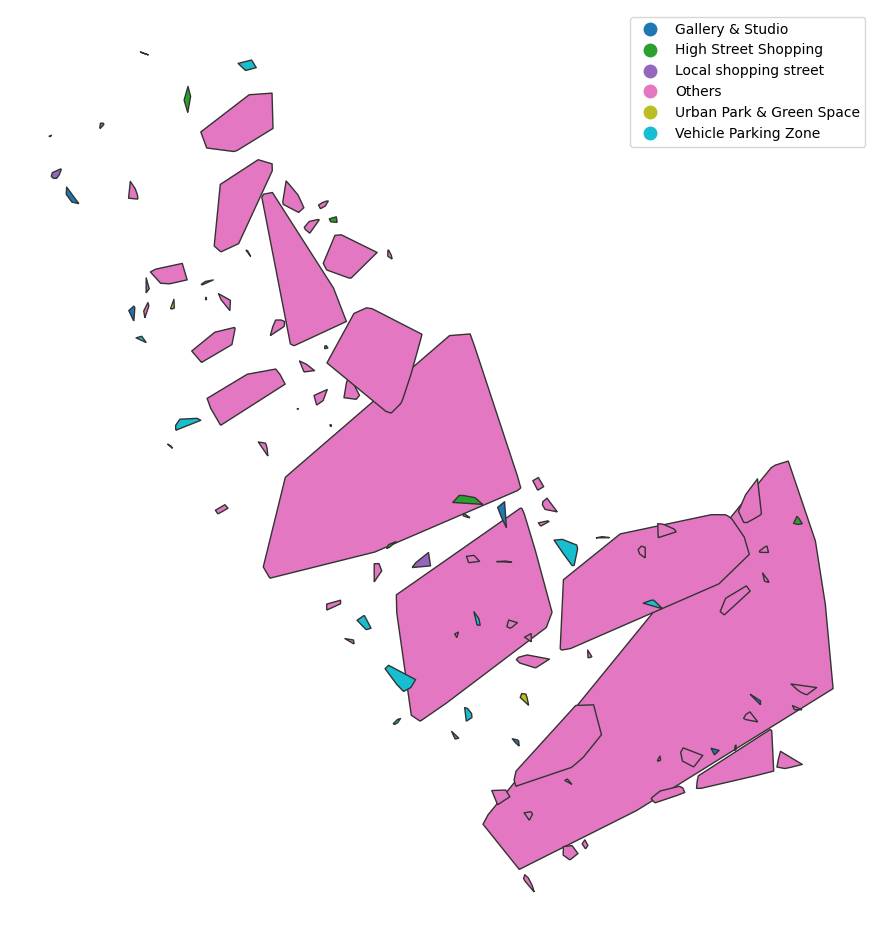

In [ ]:
#Mapping
bertopic_gdf = gpd.GeoDataFrame(bertopic_df, geometry="geometry", crs='EPSG:27700')
# create figure and axes for Matplotlib
fig, ax = plt.subplots(figsize=(20, 12))
bertopic_gdf.plot(column='BERTopic_OSM',
                      categorical = True  ,
                      edgecolor='0.2',
                      cmap='tab10',
                      ax=ax,
                      legend = True
                      #legend_kwds={'label': "K-means Cluster", 'orientation': 'vertical'}
                     )
ax.set_axis_off()

In [ ]:
bertopic_gdf.to_csv('bertopic_kc_osm_agile.csv')
files.download('bertopic_kc_osm_agile.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>